# PCA for Facial Image Recognition

## Introduction

In this lesson you'll get to explore an exciting application of PCA: as preprocessing for facial image recognition!

## Objectives

You will be able to:
* Load the Olivetti Dataset using sci-kit learn
* See the performance gains of using PCA as a preprocessing step for complex datasets in machine learning pipelines

## Loading the Data

First, let's load the dataset.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

In [2]:
data = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/web-modal-2733/scikit_learn_data


## Previewing the Images in the Dataset

Next, we'll take a quick preview of the images within the dataset.

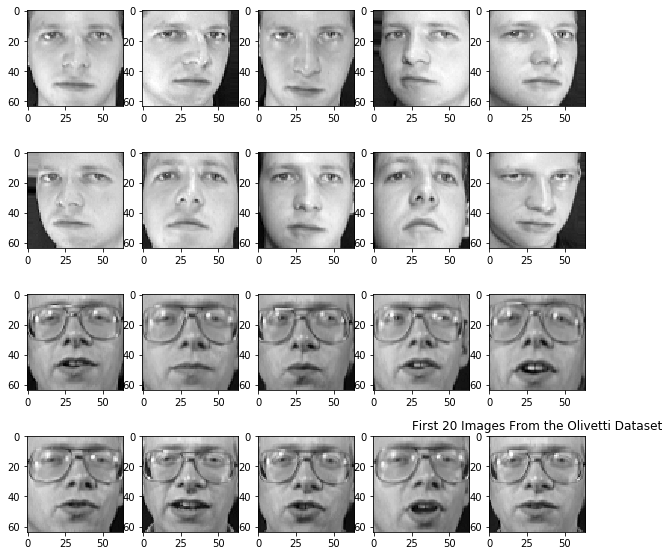

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
for n in range(20):
    i = n //5
    j = n%5
    ax = axes[i][j]
    ax.imshow(data.images[n], cmap=plt.cm.gray)
plt.title('First 20 Images From the Olivetti Dataset');

## Training a Baseline Classifier

In a minute, you'll take a look at the performance gains by using PCA as a preprocessing technique. To compare the performance, here's an out of the box classifier's performance.

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [5]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=22)

In [6]:
clf = svm.SVC(C=5, gamma=0.05)
%timeit clf.fit(X_train, y_train)

1.08 s ± 8.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.74


## Grid Search on the Baseline Classifier

To produce a more robust baseline to compare against, let's see how much performance you can squeeze out of an initial model. To do that, you could run a grid search to find optimal hyperparameters for the model. It's also worth timing the duration of training such a model, as PCA will drastically decrease training time, and it's interesting to observe this performance gain.

> **Warning**: It's not recommended to run the cell below. (Doing so is apt to take well over an hour, depending on the particular specs of your machine.)

In [8]:
import numpy as np
from sklearn.model_selection import GridSearchCV

clf = svm.SVC()
param_grid = {"C" : np.linspace(.1, 10, num=11),
             "gamma" : np.linspace(10**-3, 5, num=11)}
grid_search = GridSearchCV(clf, param_grid, cv=5)
%timeit grid_search.fit(X_train, y_train)

10min 17s ± 6.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
grid_search.best_estimator_.score(X_test, y_test)

0.91

## Preprocessing with PCA

Now, it's time to perform some dimensionality reduction with PCA! To start, you can simply pick an arbitrary number of components. Later, you could compare the performance of a varying number of components.

Note that to avoid information leakage from the test set, PCA should only be fit on the training data.

In [8]:
from sklearn.decomposition import PCA

In [9]:
X[0].shape

(4096,)

In [10]:
pca = PCA(n_components=100, whiten=True)
X_pca_train = pca.fit_transform(X_train)
X_pca_train.shape

(300, 100)

In [14]:
X_pca_train[299].shape

(100,)

## Exploring the Explained Variance Captured by Principal Components

How much of the total data was capture in these compressed representations? Take a quick look at a plot of the explained variance to explore this.

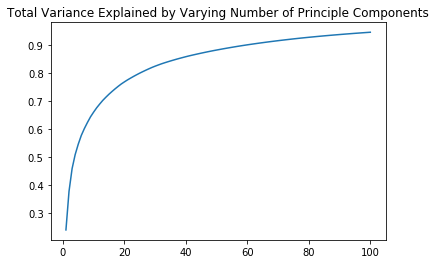

In [15]:
plt.plot(range(1,101), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

## Training a Classifier on the Compressed Dataset

Now its time to compare the performance of a classifier trained on the compressed dataset.

In [18]:
X_pca_test = pca.transform(X_test)
clf = svm.SVC()
clf.fit(X_pca_train, y_train)

/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
train_pca_acc = clf.score(X_pca_train, y_train)
test_pca_acc = clf.score(X_pca_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_pca_acc, test_pca_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.93


## Grid Search for Appropriate Parameters

Going further, you can also refine the model using grid search.

In [21]:
import numpy as np
from sklearn.model_selection import GridSearchCV
clf = svm.SVC()
param_grid = {"C" : np.linspace(.1, 10, num=11),
             "gamma" : np.linspace(10**-3, 5, num=11)}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_pca_train, y_train)

/opt/conda/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([ 0.1 ,  1.09,  2.08,  3.07,  4.06,  5.05,  6.04,  7.03,  8.02,
        9.01, 10.  ]), 'gamma': array([1.0000e-03, 5.0090e-01, 1.0008e+00, 1.5007e+00, 2.0006e+00,
       2.5005e+00, 3.0004e+00, 3.5003e+00, 4.0002e+00, 4.5001e+00,
       5.0000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
grid_search.best_params_

{'C': 10.0, 'gamma': 0.001}

In [20]:
grid_search.best_estimator_.score(X_pca_test, y_test)

0.89

## Visualizing Some of the Features Captured by PCA

While the model is clearly more accurate and faster to train, let's take a moment to circle back and visualize some of the information captured by PCA. Specifically, you'll take a look at 2 perspectives. First, you'll take a look at visualizing the feature means. Second, you'll get to visualize the compressed encodings of the dataset.

### Visualizing Feature Means

While a very simple mathematical model, just observing the mean values of the features produces quite an informative picture:

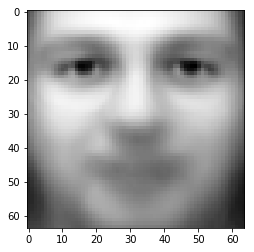

In [22]:
plt.imshow(X.mean(axis=0).reshape(data.images[0].shape), cmap=plt.cm.gray)

### Visualizing Compressed Representations

Visualizing the components from PCA is slightly tricky, as they have new dimensions, which may not correspond accurately to the 64x64 size of the original images. Fortunately, sci-kit learn provides a useful `inverse_transformation` method to PCA allowing you to reproject the compressed dataset back to the original size. This allows you to observe what features are retrieval and encapsulated within the principle components.

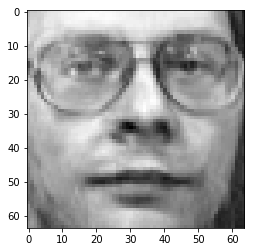

In [23]:
fig, axes
plt.imshow(pca.inverse_transform(X_pca_train[0]).reshape(64,64), cmap=plt.cm.gray)

To make this even more interesting, take a look at some of the varied levels of detail based on varying number of principle components:

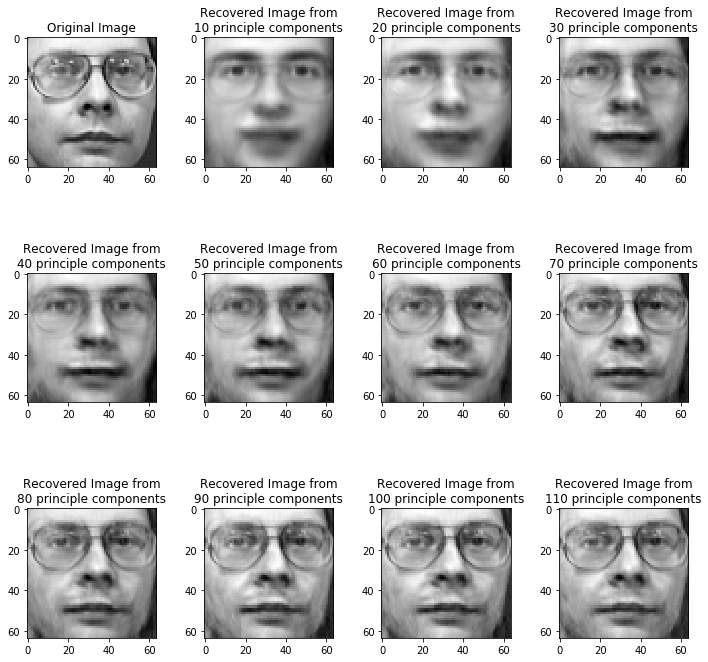

In [24]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(10,10))
ax = axes[0][0]
ax.set_title('Original Image')
ax.imshow(X_train[0].reshape(64,64), cmap=plt.cm.gray)
for n in range(1,12):
    i = n //4
    j = n%4
    ax = axes[i][j]
    ax.set_title('Re')
    n_feats = n*10
    pca = PCA(n_components=n_feats)
    pca.fit(X_train)
    compressed = pca.transform(X_train)
    ax.set_title('Recovered Image from\n{} principle components'.format(n_feats))
    ax.imshow(pca.inverse_transform(compressed[0]).reshape(64,64), cmap=plt.cm.gray)
plt.tight_layout()

## Summary

Awesome! In this lesson, you got to preview of using PCA to reduce the dimensionality of a complex dataset. In the next lab, you'll get a chance to put these same procedures to test in working with the MNIST dataset.